In [2]:
# some imports
import os
import numpy as np
import pickle
from functools import reduce
import operator
from glob import glob
%matplotlib notebook
from matplotlib import pyplot as plt
from natsort import natsorted
import keras
from keras.optimizers import Adam

# import custom functions and viewing tools
from VisTools import DisplayDifferenceMask, mask_viewer0
from KerasModel import BlockModel, dice_coef_loss, CalcVolumes

Using TensorFlow backend.


In [3]:
#~# some parameters to set for inference #~#
# model version to use
model_version = 5
model_weights_path = os.path.join(os.getcwd(),
                                  'BestModelWeights_dataset2_v{:02d}.h5'.format(model_version))

In [4]:
# load testing data
with open('test_input_files.pkl'.format(model_version), 'rb') as f:
    test_input_files = pickle.load(f)
with open('test_target_files.pkl'.format(model_version), 'rb') as f:
    test_target_files = pickle.load(f)
# find unique sequence names
sequences = [os.path.split(os.path.dirname(f))[1] for f in test_input_files]
unq_sequences = list(set(sequences))
# resplit by sequence
grouped_input_files = [[f for f in test_input_files if s in f] for s in unq_sequences]
grouped_target_files = [[f for f in test_target_files if s in f] for s in unq_sequences]

In [5]:
print('Loading data...')
inputs = [np.concatenate([np.load(f) for f in g])[...,np.newaxis] for g in grouped_input_files]
targets = [np.concatenate([np.load(f) for f in g])[...,np.newaxis] for g in grouped_target_files]
print("Data loaded")

Loading data...
Data loaded


In [40]:
grouped_input_files

[['/home/bashirmllab/dataset2/SSFSE_output/input_JKB01_001_07_A_SSFSE.npy',
  '/home/bashirmllab/dataset2/SSFSE_output/input_JKB01_001_07_B_SSFSE.npy',
  '/home/bashirmllab/dataset2/SSFSE_output/input_JKB01_001_07_C_SSFSE.npy',
  '/home/bashirmllab/dataset2/SSFSE_output/input_JKB01_005_03_A_SSFSE.npy',
  '/home/bashirmllab/dataset2/SSFSE_output/input_JKB01_005_03_C_SSFSE.npy',
  '/home/bashirmllab/dataset2/SSFSE_output/input_JKB01_003_03_B_SSFSE.npy',
  '/home/bashirmllab/dataset2/SSFSE_output/input_JKB01_001_26_A_SSFSE.npy',
  '/home/bashirmllab/dataset2/SSFSE_output/input_JKB01_001_26_B_SSFSE.npy',
  '/home/bashirmllab/dataset2/SSFSE_output/input_JKB01_001_26_C_SSFSE.npy',
  '/home/bashirmllab/dataset2/SSFSE_output/input_JKB01_005_10_B_SSFSE.npy',
  '/home/bashirmllab/dataset2/SSFSE_output/input_JKB01_005_10_C_SSFSE.npy',
  '/home/bashirmllab/dataset2/SSFSE_output/input_JKB01_001_10_A_SSFSE.npy',
  '/home/bashirmllab/dataset2/SSFSE_output/input_JKB01_001_10_C_SSFSE.npy',
  '/home/bas

In [6]:
# prepare model
model = BlockModel(inputs[0].shape,filt_num=16,numBlocks=4)
model.compile(optimizer=Adam(), loss=dice_coef_loss)

# load best weights
model.load_weights(model_weights_path)
# evaluate on test data
print('Evaluating data...')
for i,d in enumerate(unq_sequences):
    score = model.evaluate(inputs[i],targets[i],verbose=1)
    print("Test Dice score on {} is {:.03f}".format(d,1-score))

Evaluating data...
854/854 [==============================] - 17s 20ms/step
Test Dice score on SSFSE_output is 0.945
1056/1056 [==============================] - 16s 15ms/step
Test Dice score on t1nfs_output is 0.893
205/205 [==============================] - 4s 18ms/step
Test Dice score on opposed_output is 0.910


In [7]:
# Get predicted masks
output = [model.predict(inp,batch_size=16) for inp in inputs]

In [160]:
truth = np.round(disp_truth[ind,...,0]).astype(np.int)
pred = np.round(disp_pred[ind,...,0]).astype(np.int)
intersection = np.sum(truth * pred)
denom = np.sum(truth) + np.sum(pred)
dice = 2*intersection/denom

In [163]:
def CalcDice(truth,pred):
    truth = np.round(truth).astype(np.int)
    pred = np.round(pred).astype(np.int)
    intersection = np.sum(truth * pred)
    denom = np.sum(truth) + np.sum(pred)
    return 2*intersection/denom

<IPython.core.display.Javascript object>


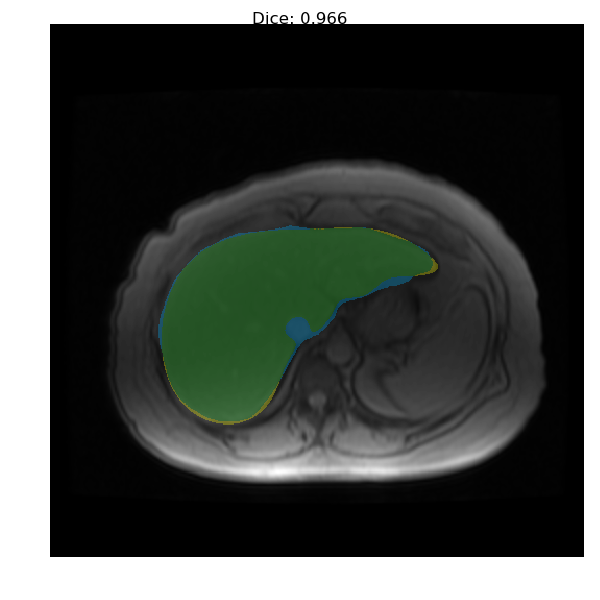

In [187]:
# display image of index and subject of choice
seq = 2
subj = 1
ind = 21
ims = np.load(grouped_input_files[seq][subj])[...,np.newaxis]
truth = np.load(grouped_target_files[seq][subj])[...,np.newaxis]
pred = model.predict(ims)
disp_im = ims[ind,...,0]
disp_truth = truth[ind,...,0]
disp_pred = pred[ind,...,0]
cur_dice = CalcDice(disp_truth,disp_pred)
DisplayDifferenceMask(disp_im,disp_truth,disp_pred,name='Dice: {:.03f}'.format(cur_dice))

In [ ]:
# display some results
seq_num = 0
print('Generating {} masks...'.format(unq_sequences[seq_num]))
mask_viewer0(inputs[seq_num][...,0],targets[seq_num][...,0],output[seq_num][...,0],name=unq_sequences[seq_num])
plt.show()

Below section not yet fully updated for dataset2 analysis

In [ ]:
# set voxel dimensions (in cm)
sx = 1
sy = 1
sz = 1
vox_vol = sx*sy*sz
# loop over different sequence types
for sequence in all_inputs:
    # loop over all subjects
    results = []
    for inp_file,targ_file in zip(all_inputs,all_targets):
        # run function to perform calculations
        calc,truth = CalcVolumes(inp_file,targ_file,vox_vol,model)
        results.append((calc,truth))
# display results
print('---------------------------------------')
print(inp_file[-30:])
print("The calculated volume is {:.02f} voxels".format(calc))
print("The actual volume is {:.02f} voxels".format(truth))

In [ ]:
x = [r[1] for r in results]
y = [r[0] for r in results]
plt.figure()
plt.plot(x,y,'ro')
plt.plot(np.arange(0,np.max(x)),np.arange(0,np.max(x)),'k--')
plt.xlim([0,np.max(x)])
plt.ylim([0,np.max(y)])
plt.ylabel('Calculated Volume (cc)')
plt.xlabel('Actual Volume (cc)')
plt.title("Correlation of Actual and Predicted Liver Volumes of Test Subjects")
plt.show()
cc = np.corrcoef(x,y)[0,1]
print('Correlation coefficient is {:.03f}'.format(cc))